In [1]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt

from Miniproject_2.model import *

import torch
from torch.nn import functional as F


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

valid_input, valid_target = torch.load('../val_data.pkl',map_location=device)#validation set (noise-clean)
train_input, train_target = torch.load('../train_data.pkl',map_location=device) #test set (noise-noise)

num_samples = 1000
valid_input=torch.narrow(valid_input,0,0,num_samples)
valid_target=torch.narrow(valid_target,0,0,num_samples)
train_input=torch.narrow(train_input,0,0,num_samples)
train_target=torch.narrow(train_target,0,0,num_samples)

# plt.imshow(valid_input[164].permute(1,2,0))

print("Vector shape: ",train_input.shape)

Vector shape:  torch.Size([1000, 3, 32, 32])


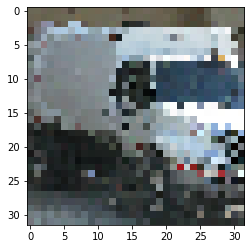

In [3]:
idx = 164
len = 1
a=valid_input[[idx]].float()/255.
target=valid_target[idx].float()/255.
plt.imshow(a[0].permute(1,2,0))

In [4]:
f = torch.empty(5,3,3,3)

f[0, 0] = torch.tensor([ [ +0., +0., -1. ], [ +0., +1., +0. ], [ -1., +0., +0. ]])
f[1, 0] = torch.tensor([ [ +1., +1., +1. ], [ +1., +1., +1. ], [ +1., +1., +1. ]])
f[2, 0] = torch.tensor([ [ -1., +0., +1. ], [ -1., +0., +1. ], [ -1., +0., +1. ]])
f[3, 0] = torch.tensor([ [ -1., -1., -1. ], [ +0., +0., +0. ], [ +1., +1., +1. ]])
f[4, 0] = torch.tensor([ [ +0., -1., +0. ], [ -1., +4., -1. ], [ +0., -1., +0. ]])

for j in range(0,5):
    for i in range(1,3):
        f[j,i] = f[j,0]

ff = f.transpose(0,1)
ff.requires_grad_();

In [5]:
out = F.conv2d(a,f)
out.shape

torch.Size([1, 5, 30, 30])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


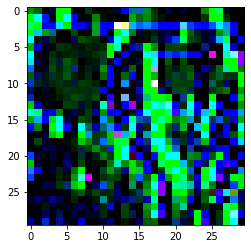

In [6]:
plt.imshow(out[0].permute(1,2,0)[:,:,::2])

In [48]:
stride = 2
kernel_size = 2

conv1 = Conv2d(3,5, kernel_size, stride=stride, padding=0, dilation=1)
# conv1.weight=f
relu1 = Relu()
conv2 = Conv2d(5,5,kernel_size, stride=stride, padding=0, dilation=1)
relu2 = Relu()
tconv3 = ConvTranspose2d(5,5, kernel_size, stride=stride, padding=0, dilation=1)
relu3 = Relu()
tconv4 = ConvTranspose2d(5,3, kernel_size, stride=stride, padding=0, dilation=1)
sig4 = Sigmoid()

net = Sequential(conv1,  
                relu1,  
                conv2, 
                relu2, 
                tconv3,
                relu3, 
                tconv4,
                sig4
                )

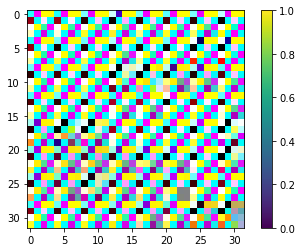

In [49]:
out=net(a)
plt.imshow(out[0].permute(1,2,0)[:,:,:])
plt.colorbar()

In [50]:
out.shape

torch.Size([1, 3, 32, 32])

In [10]:
# Test MSE loss
idx = 22
len = 10
input=valid_input[idx].float()
target=valid_target[idx].float()

# fig,ax = plt.subplots(1,2, figsize=(8,8))
# ax[0].imshow(input.permute(1,2,0))
# ax[1].imshow(target.permute(1,2,0))
out = MSELoss().forward(input,target)

print(out)

out_true = F.mse_loss(input,target, reduction='mean')
print(out_true)

tensor(457.2217)
tensor(457.2217)
